In [1]:
from tensorflow.python.keras.utils import get_file
import gzip
import numpy as np
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import applications
import cv2
import functools
from keras.models import load_model
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 使用第2个GPU

Using TensorFlow backend.


In [2]:
# 数据集与代码放在一起即可
def load_data():
    paths = [
        'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
        't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
    ]

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28, 1)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28, 1)

    return (x_train, y_train), (x_test, y_test)

## 读取数据与数据预处理

In [6]:
 # read dataset
(x_train, y_train), (x_test, y_test) = load_data()
batch_size = 32
num_classes = 10
epochs = 5
data_augmentation = True  # 图像增强
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models_transfer_learning')
model_name = 'keras_fashion_transfer_learning_trained_model.h5'


# Convert class vectors to binary class matrices.  将类别弄成独热编码
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# 由于mist的输入数据维度是(num, 28, 28)，vgg16 需要三维图像,因为扩充一下mnist的最后一维
X_train = [cv2.cvtColor(cv2.resize(i, (48, 48)), cv2.COLOR_GRAY2RGB) for i in x_train]
X_test = [cv2.cvtColor(cv2.resize(i, (48, 48)), cv2.COLOR_GRAY2RGB) for i in x_test]

x_train = np.asarray(X_train)
x_test = np.asarray(X_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255  # 归一化
x_test /= 255  # 归一化


## 迁移学习建模

In [7]:
# 使用VGG16模型
base_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])  # 第一层需要指出图像的大小

# # path to the model weights files.
# top_model_weights_path = 'bottleneck_fc_model.h5'
print(x_train.shape[1:])
model = Sequential()
print(base_model.output)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# add the model on top of the convolutional base
model = Model(inputs=base_model.input, outputs=model(base_model.output))  # VGG16模型与自己构建的模型合并

# 保持VGG16的前15层权值不变，即在训练过程中不训练  
for layer in model.layers[:15]:
    layer.trainable = False

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

(48, 48, 3)
Tensor("block5_pool_1/MaxPool:0", shape=(?, 1, 1, 512), dtype=float32)


## 训练

In [8]:
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    print(x_train.shape[0]//batch_size)  # 取整
    print(x_train.shape[0]/batch_size)  # 保留小数
    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,  # 按batch_size大小从x,y生成增强数据
                                     batch_size=batch_size),  
                        # flow_from_directory()从路径生成增强数据,和flow方法相比最大的优点在于不用
                        # 一次将所有的数据读入内存当中,这样减小内存压力，这样不会发生OOM
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=10  # 在使用基于进程的线程时，最多需要启动的进程数量。
                       )

Using real-time data augmentation.
1875
1875.0
Epoch 1/5
1875/1875 [==============================] - 1144s 610ms/step - loss: 0.4936 - acc: 0.8304 - val_loss: 0.3751 - val_acc: 0.8639
Epoch 2/5
1875/1875 [==============================] - 855s 456ms/step - loss: 0.3874 - acc: 0.8690 - val_loss: 0.3440 - val_acc: 0.8810
Epoch 3/5
1875/1875 [==============================] - 825s 440ms/step - loss: 0.3633 - acc: 0.8799 - val_loss: 0.3488 - val_acc: 0.8914
Epoch 4/5
1875/1875 [==============================] - 1563s 834ms/step - loss: 0.3491 - acc: 0.8855 - val_loss: 0.3238 - val_acc: 0.8998
Epoch 5/5
1875/1875 [==============================] - 1929s 1s/step - loss: 0.3443 - acc: 0.8911 - val_loss: 0.3749 - val_acc: 0.8878


## 模型可视化与保存模型

In [9]:
model.summary()
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

## 训练过程可视化

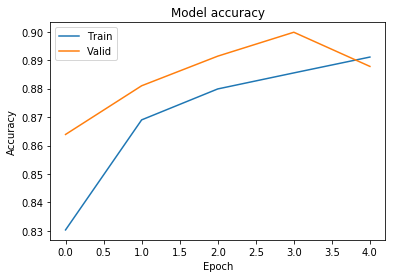

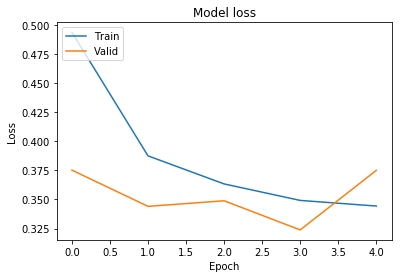

In [11]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('tradition_cnn_valid_acc.png')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('tradition_cnn_valid_loss.png')
plt.show()